# TestFourierTransform

## FFT of waveform

Import necessary modules

In [1]:
import numpy as np
import scipy as sc
import scipy.fft as scfft
import matplotlib.pyplot as plt
import uproot

In [2]:
from Functions import *

In [3]:
CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(23,1017)

In [4]:
print(CombinedFile.keys())
print('---------------')
#print(CombinedFile['combined'].show(name_width=60))
#print(CombinedFile['combined']['header']['trigger_time'])
TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')

['combined;5', 'combined;4', 'info;1']
---------------


In [14]:
for i in TriggerTimes:
    print(i)

1664070443.8589115
1664070450.3810034
1664070452.2100737
1664070478.370427
1664070479.1388505
1664070507.5427377
1664070555.2072358
1664070555.4769955
1664070556.3502052
1664070556.5871446
1664070582.0431688
1664070597.9469562
1664070598.3346436
1664070609.3645282
1664070625.807652
1664070651.7358599
1664070652.9284625
1664070653.0633404
1664070655.1387708
1664070656.1588814
1664070655.9208798
1664070657.0556376
1664070656.2997634
1664070657.655352
1664070656.8317978
1664070661.8231723
1664070669.0687926
1664070671.2358513
1664070678.7097125
1664070710.506033
1664070716.5505202
1664070733.4561653
1664070733.936633
1664070741.6810627
1664070746.1228235
1664070754.615439
1664070770.7177546
1664070777.891307
1664070795.9198833
1664070802.2960396
1664070825.6106918
1664070842.1072884
1664070863.844253
1664070863.0222964
1664070865.3184764
1664070867.4523087
1664070871.8513145
1664070881.5422888
1664070891.6284134
1664070911.1433692
1664070914.193201
1664070915.3075848
1664070914.7136333
16

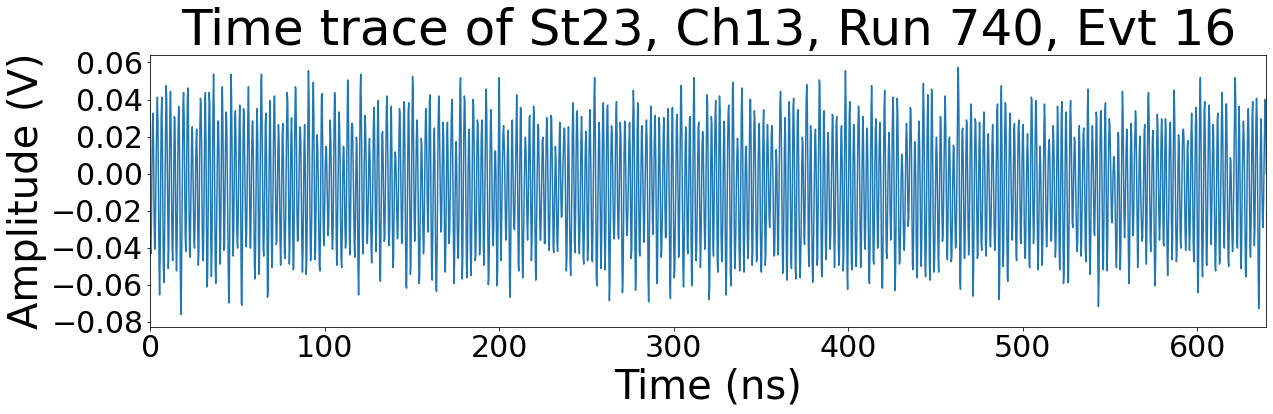

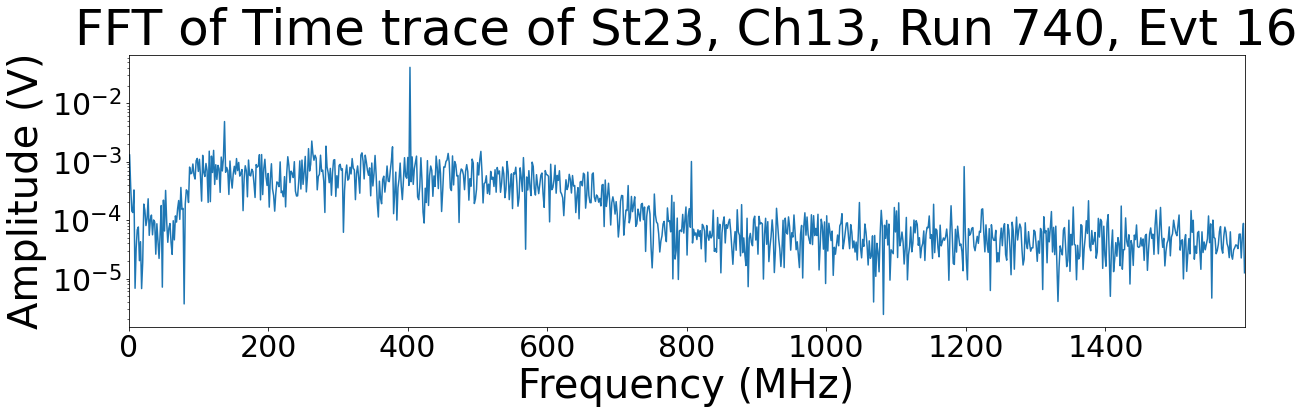

In [4]:
TimeTrace(23,13,740,16,Amplitude="V")
TimeTraceFFT(23,13,740,16,Amplitude="V",LogScale=True)

In [6]:
CmbFile=GetCombinedFile(22,712)
CmbFile['combined'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
waveforms            | mattak::Waveforms        | AsGroup(<TBranchElement 'wa...
waveforms/TObject    | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
waveforms/TObject... | uint32_t                 | AsDtype('>u4')
waveforms/TObject... | uint8_t                  | AsDtype('uint8')
waveforms/run_number | uint32_t                 | AsDtype('>u4')
waveforms/event_n... | uint32_t                 | AsDtype('>u4')
waveforms/station... | uint16_t                 | AsDtype('>u2')
waveforms/buffer_... | uint16_t                 | AsDtype('>u2')
waveforms/radiant... | int16_t[24][2048]        | AsDtype("('>i2', (24, 2048))")
header               | mattak::Header           | AsGroup(<TBranchElement 'he...
header/TObject       | (group of fUniqueID:u... | AsGroup(<TBranchElement 'TO...
header/TObject/fU... | uint32_t          

def FilesStRun(StNr,RunNr):
    path=Path(StNr,RunNr)
    CombinedFile=uproot.open(path+"/combined.root")
    DAQStatFile=uproot.open(path+"/daqstatus.root")
    HeadersFile=uproot.open(path+"/headers.root")
    PedestalFile=uproot.open(path+"/pedestal.root")
    return CombinedFile, DAQStatFile, HeadersFile, PedestalFile

def DailyVoltAvg(StNr,ChNr,Runs,NBins=24,ZeroAvg=True,TimeFormat="LST",Triggers=(5,5,5,5),StdCut=-1,FFTFilter=True,Lowpass=False):
    """
    Plots the Average V_RMS as a function of time of the day.
    Parameters:
    StNr,ChNr,Runs=Station number, channel number, list of runs 
    NBins=amount of bins to divide the full day in
    ZeroAvg=Boolean: if true, the timetraces will firs tbe zero averaged
    Lowpass= Boolean: if true, a butterworth lowpass filter will be applied in order to maintain only galactic noise dominated frequencies
    FFTFilter=Boolean: if true, applies a Notch filter to all frequency spectra to cut out frequencies which have shown to be potentially problematic
    TimeFormat= String: Dictates what timeformat the x-axis will be in. Options: "LST": local sidereal time, "LT": Local time & "UTC": UTC time
    Triggers=tupel of flags to dictate which triggers are allowed in the analysis. Events with different triggers are not used (0=has to be absent, 1=has to be present, anything else=both 0 and 1 can be used for analysis)
    StdCut=if larger than zero, all VRMS outliers above StdCut standard variations will be cut out of the analysis
    """
    (has_rf,has_ext,has_pps,has_soft)=Triggers
    NEvs=0
    EventRMS=np.array([]) #Array to store V_RMS value of each event
    EventTime=np.array([])#Array to store timestamp of each event
    #for (Run, EvNr) in TriggerFilterAlt(StNr, ChNr, Runs,has_rf,has_ext,has_pps,has_soft):
    for (Run,EvNr) in TriggerFilterAlt(StNr, ChNr, Runs,has_rf,has_ext,has_pps,has_soft):
        path=Path(StNr,Run)
        #if os.path.isdir(path+"/combined.root"):
        if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):
            NEvs+=1
        
            CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(StNr,Run)
            RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')        
                
            EvIndex=np.where(EventNrs==EvNr)[0][0]
            VoltageTrace=ADCtoVoltage(RadiantData[EvIndex][ChNr]) #The timetrace data in voltage
            if ZeroAvg==True:
                Vmean=np.mean(VoltageTrace)
                VoltageTrace-=Vmean
                #EventRMS=np.append(EventRMS,np.sqrt(np.mean([(V-Vmean)**2 for V in ADCtoVoltage(RadiantData[EvIndex][ChNr])])))
            if FFTFilter or Lowpass:
                sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
                TimeStep=1/sampling_rate #Time between two samples
                SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
                freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
                freq=np.fft.fftshift(freq)
                TotalFilter=np.ones(len(freq))
                if FFTFilter:
                    TotalFilter=np.multiply(TotalFilter,NotchFilters([403*10**6,120*10**6,807*10**6,1197*10**6],75,freq,sampling_rate))
                if Lowpass:
                    CritFreq=110*10**6
                    TotalFilter=np.multiply(TotalFilter,LowpassButter(CritFreq,20,freq))
                FFT=scfft.fft(VoltageTrace)
                FFT=np.fft.fftshift(FFT)
                FFT=np.array([FFT[i]*TotalFilter[i] for i in range(len(freq))])
                VoltageTrace=np.abs(scfft.ifft(FFT))
            
            EventRMS=np.append(EventRMS,np.sqrt(np.mean([V**2 for V in VoltageTrace])))
                
            if TimeFormat=="LST":
                EventTime=np.append(EventTime,LST(TriggerTimes,EvIndex))
            elif TimeFormat=="LT": #Greenland Timezone is UTC-3
                EventTime=np.append(EventTime,(UTC(TriggerTimes,EvIndex)-3)%24)
            else:
                print("Please enter a valid TimeFormat")
                return

In [ ]:
runs, evnrs=np.empty(), np.empty()

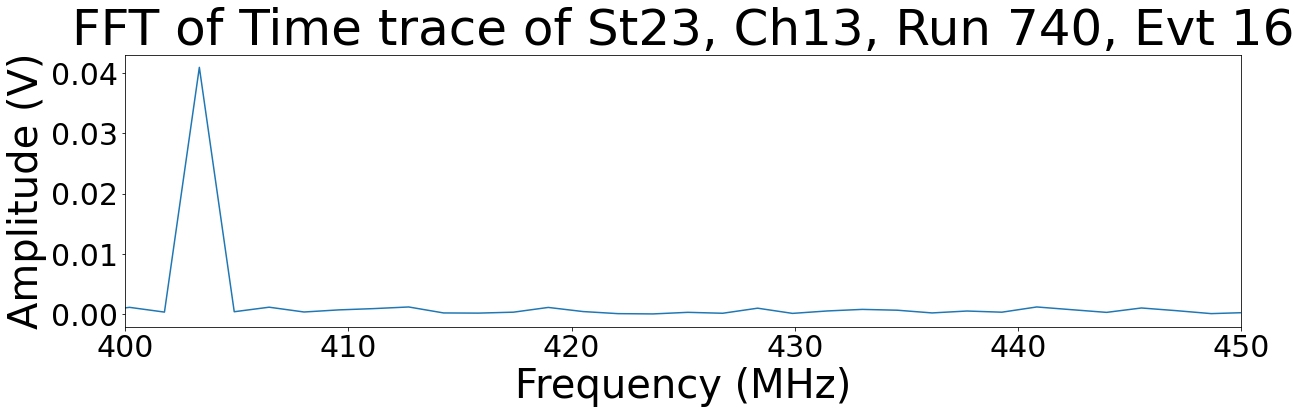

In [3]:
TimeTraceFFT(23,13,740,16,Amplitude="V")

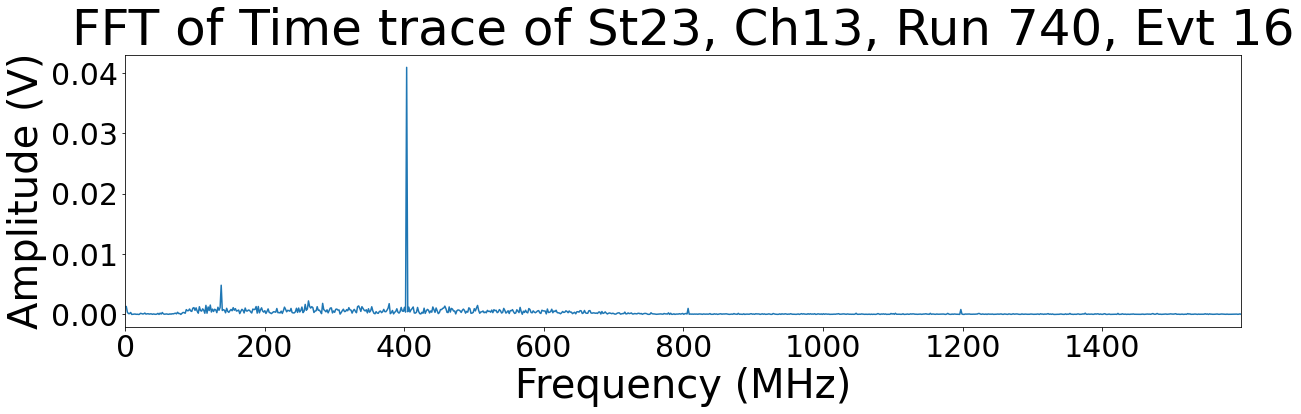

In [3]:
TimeTraceFFT(23,13,740,16,Amplitude="V")

Deze cell is om een verandering aan te brengen om te oefenen met GitHub push & pull

In [12]:
import os
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units
from NuRadioReco.framework import event,station, channel
path = os.path.dirname(detector.__file__)
path+="/RNO_G/RNO_season_2021.json"
print(path)

/storage_mnt/storage/user/jstoffels/software/jupyter_venv/lib64/python3.6/site-packages/NuRadioReco/detector/RNO_G/RNO_season_2021.json


In [16]:
name="createLPDA_100MHz_InfFirn_n1.4_InfFirn"
print(name[-8:])
print(name[:-8])

_InfFirn
createLPDA_100MHz_InfFirn_n1.4


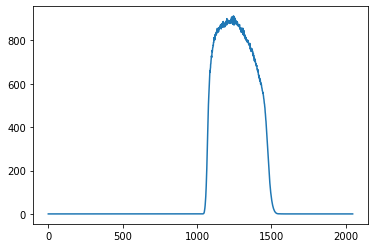

In [3]:
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units
from NuRadioReco.framework import event,station, channel
import NuRadioReco.modules.RNO_G.hardwareResponseIncorporator
import os
from datetime import datetime
import numpy as np
import scipy.fft as scfft

Date=datetime.strptime("2021-08-31","%Y-%m-%d")
detpath = os.path.dirname(detector.__file__)
detpath+="/RNO_G/RNO_season_2021.json"
    
sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
TimeStep=1/sampling_rate #Time between two samples
SamplingTimes=np.arange(0,2048*TimeStep,TimeStep)
freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
freq=np.fft.fftshift(freq)

from NuRadioReco.framework.base_trace import BaseTrace
dummy_trace = BaseTrace()
dummy_trace.set_trace(np.zeros(2048), 3.2*units.GHz)
frequencies = dummy_trace.get_frequencies()
    
GNDetector = detector.Detector(json_filename = detpath)
GNDetector.update(Date) #date in example
GNEvent=event.Event(540,11)
GNStation=station.Station(22)
GNStation.set_station_time(Date)
GNChannel=channel.Channel(13)
GNChannel.set_trace(trace=np.zeros(2048), sampling_rate=3.2 * units.GHz)
GNStation.add_channel(GNChannel) 
    

hardwareResponseIncorporator = NuRadioReco.modules.RNO_G.hardwareResponseIncorporator.hardwareResponseIncorporator()
#Filter=hardwareResponseIncorporator.get_filter(frequencies, GNStation.get_id(), GNChannel.get_id(), GNDetector, temp=293.15, sim_to_data=True, phase_only=False, mode=None, mingainlin=None)
Filter=hardwareResponseIncorporator.get_filter(freq*units.Hz, GNStation.get_id(), GNChannel.get_id(), GNDetector, temp=293.15, sim_to_data=True, phase_only=False, mode=None, mingainlin=None)
import matplotlib.pyplot as plt
plt.plot(np.abs(Filter))

In [41]:
def ReadNpArray(filename):
    with open(filename) as f:
        line = f.readline()
        NpArray=np.array([np.array([float(i) for i in line.strip(' \n').split()])])
        print(NpArray)
        while True:
            line = f.readline()
            if not line:
                break
            NpArray=np.append(NpArray,np.array([np.array([float(i) for i in line.strip(' \n').split()])]),0)
            #print(line.strip())
    return NpArray

In [3]:
import numpy as np
GalacticNoiseCurve=[np.array([]) for i in range(13)]
for i in range(100):
    Random=np.array([np.array([np.random.uniform(2,3)]) for i in range(13)])
    GalacticNoiseCurve=np.concatenate((GalacticNoiseCurve,Random),1)

print(GalacticNoiseCurve)
np.savetxt('GalacticNoiseCurveFakeResults.txt', GalacticNoiseCurve)

[[2.16757127 2.80150751 2.79383943 ... 2.22150083 2.57420966 2.27559549]
 [2.97063727 2.04711711 2.87236159 ... 2.35884828 2.70066271 2.65035399]
 [2.33220772 2.07852733 2.04441965 ... 2.08728324 2.57200806 2.014603  ]
 ...
 [2.16831938 2.81612468 2.8196949  ... 2.67110205 2.24985265 2.20094597]
 [2.8079755  2.26311992 2.89658355 ... 2.24567653 2.57574389 2.26202573]
 [2.24113254 2.6074843  2.50393665 ... 2.50982947 2.97101314 2.79164336]]


In [6]:
CombinedFile, DAQStatFile, HeadersFile, PedestalFile=FilesStRun(22,541)
RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
print(EventNrs[0])

9


In [8]:
units.Hz

1e-09